In [21]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

In [22]:
data_path = 'data/'
images = 'images/'

In [23]:
droids_df = pd.read_pickle(f'{data_path}droids_df.pkl')

In [24]:
num_classes = 2
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [25]:
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [26]:
x, y, f = [], [], []
for fileName, is_train in droids_df[['fileName', 'is_train']].values:
    droids_rects = droids_df.loc[droids_df['fileName'] == fileName]
    rects_data = droids_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{images}{fileName}.jpg')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(int(category) - 1)

In [27]:
model = keras.models.load_model('my_model/model.h5', compile=False)

In [28]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_test, y_train, y_test = x[f], x[~f], y[f], y[~f]
# save test images
x_test_images = x_test

In [29]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [30]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_test, axis=1)
y_validation_predict = model.predict(x_test)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

Accuracy:	 0.78049
Recall:		 0.66667 	 0.9
Precision:	 0.875 		 0.72
F1:		 0.75676 	 0.8


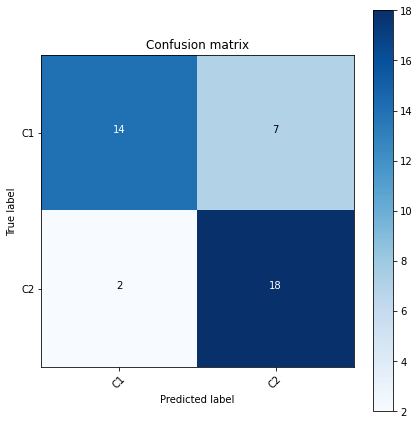

In [34]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=False)

from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

predicted = model.predict(x_test)
for i in range(len(predicted)):
    predicted[i] = np.around(predicted[i])
    
recall = recall_score(y_test, predicted, average=None)
precision = precision_score(y_test, predicted, average=None)
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted,  average=None)

print("Accuracy:\t", round(accuracy, 5))
print("Recall:\t\t", round(recall[0] ,5 ), '\t', round(recall[1] ,5 ))
print("Precision:\t", round(precision[0] ,5 ), '\t\t', round(precision[1] ,5 ))
print("F1:\t\t", round(f1[0] ,5 ), '\t', round(f1[1] ,5 ))